# Práctico 5 - Clustering

Utilizar un dataset de semillas para aplicar técnicas de clustering.

Se provee un cuaderno de Colab con el mismo: (https://colab.research.google.com/drive/127tK1Bks9gB_JvIeghTmSUhwnJg750Ff?usp=sharing)


Con el dataset resolver los siguientes puntos:


a) Describir el dataset.

b) Definir cuál es el objetivo de aplicar técnicas de clustering.

c) Obtener los clusters utilizando 2 técnicas de clustering usando la biblioteca de Python Scikit-learn. Justificar las decisiones tomadas.

d) Evaluar los clusters obtenidos y compararlos, indicando cual de los dos

recomendaría. Evaluarlos según distintas métricas.

$b)$ El objetivo de aplicar técnicas de clustering es organizar los datos en grupos o clusters de tal manera que todos los elementos de un grupo tengan la mayor similitud posible entre ellos, pero que estos difieran lo más posible de los elementos de otros clusters. En otras palabras, se busca tener una alta similitud intra-cluster y una baja similitud inter-cluster. De esta forma, se pueden descubrir patrones entre los datos, que probablemente antes no eran conocidos dado que en general se suele acudir a este tipo de técnicas cuando no hay una clase definida para los elementos (por ejemplo agrupando a usuarios de una plataforma de películas por sus visualizaciones, para futuras recomendaciones, que es una de las diversas formas de aplicar un sistema de recomendación en ese caso). Aunque también es posible y válido aplicarla si se tienen datos etiquetados pero se quieren buscar agrupamientos nuevos, descubriendo características o relaciones que de otra forma habría sido más complejo de detectar. También se pueden analizar posibles outliers que queden fuera de ciertos grupos, aunque de esto depende mucho el tipo de algoritmo o modelo empleado y la configuración elegida.

Puntualmente en este caso se busca detectar grupos de datos similares en un dataset compuesto por elementos con 7 features numéricas y una clase con posibles valores 1, 2 y 3. Evidentemente es un dataset que puede ser utilizado para un entrenamiento supervisado por el hecho de haber una columna objetivo de antemano y conocer las posibles etiquetas. De todos modos, se realizará un entrenamiento no supervisado por medio de técnicas de clustering a partir de las 7 features (no se considerará la clase original para entrenar porque no tendría sentido), y se tomarán los labels como ground truth luego para una evaluación con criterio externo. También se llevará a cabo una evaluación por criterio interno para ver qué resultados se tendrían partiendo de un análisis por la inercia de los clusters en el caso del método del codo (Elbow Method), o por el método de siluetas (Silhouette).

In [ ]:
! pip install ydata-profiling

Se cargan los datos correspondientes al dataset 1499 de OpenMl. Se puede ver que hay 7 columnas asociadas a features numéricas y una clase con posibles etiquetas 1, 2 y 3.

In [ ]:
from sklearn.datasets import fetch_openml

# Lee el dataset seeds (1499) desde OpenMl utilizando la funcionalidad de SKLearn
seeds_dataset = fetch_openml(data_id=1499)
features = seeds_dataset.data
original_targets = seeds_dataset.target
print(features)
print(original_targets)

        V1     V2      V3     V4     V5     V6     V7
0    15.26  14.84  0.8710  5.763  3.312  2.221  5.220
1    14.88  14.57  0.8811  5.554  3.333  1.018  4.956
2    14.29  14.09  0.9050  5.291  3.337  2.699  4.825
3    13.84  13.94  0.8955  5.324  3.379  2.259  4.805
4    16.14  14.99  0.9034  5.658  3.562  1.355  5.175
..     ...    ...     ...    ...    ...    ...    ...
205  12.19  13.20  0.8783  5.137  2.981  3.631  4.870
206  11.23  12.88  0.8511  5.140  2.795  4.325  5.003
207  13.20  13.66  0.8883  5.236  3.232  8.315  5.056
208  11.84  13.21  0.8521  5.175  2.836  3.598  5.044
209  12.30  13.34  0.8684  5.243  2.974  5.637  5.063

[210 rows x 7 columns]
0      1
1      1
2      1
3      1
4      1
      ..
205    3
206    3
207    3
208    3
209    3
Name: Class, Length: 210, dtype: category
Categories (3, object): ['1', '2', '3']


In [ ]:
import pandas as pd

full_dataset = pd.concat([features, original_targets], axis=1) # se concatenan las features originales del modelo y su clase para contar con el dataset completo
full_dataset.head()

V1     V2      V3     V4     V5     V6     V7 Class
0  15.26  14.84  0.8710  5.763  3.312  2.221  5.220     1
1  14.88  14.57  0.8811  5.554  3.333  1.018  4.956     1
2  14.29  14.09  0.9050  5.291  3.337  2.699  4.825     1
3  13.84  13.94  0.8955  5.324  3.379  2.259  4.805     1
4  16.14  14.99  0.9034  5.658  3.562  1.355  5.175     1

$a)$ Se grafica a partir de Seaborn la distribución de los elementos del dataset a nivel de cada y feature y entre cada par de ellas, identificando cada punto por su clase asociada. Esto permite dar una idea gráfica de qué columnas poseen un coeficiente de correlación de Pearson más significativo respecto a la clase, y cómo entre sí generan una dependencia conjunta más o menos significativa. Esto es fundamental ya que al tener una mayor correlación con la clase, y entre sí respecto a la clase, más permitirán formar clusters de mejor calidad que se parecerán más a las etiquetas reales. Está claro que en un problema real de clustering pocas veces se cuenta con una cantidad significativa de datos etiquetados, por lo que este análisis no tendría tanto sentido (de hecho en este caso real si el dataset representa correctamente a la generalidad de los datos en la realidad, quizás sería preferible un entrenamiento supervisado).

Se puede ver a priori que por ejemplo la feature V2 en función de V4 tiene una significativa correlación con la clase. Y si bien es buena, quizá no permite deducir por clustering esta separación real de los datos de forma tan sencilla, porque aunque la similitud intra-clase (lo que si todo sale relativamente bien debería traducirse en la separación inter-cluster más adelante) es muy alta, la inter-clase no es tan baja, sobre todo entre los elementos de la clase 1 y 3 y los de la clase 1 y 2. Pero en términos generales, pareciera ser una de las relaciones que mejor puede rendir para el clustering.

En cambio, la feature V3 en función de V6 demuestra una correlación no tan buena con la clase por tener menor similitud intra-clase (entonces esto no será lo que más aportará al clustering), y una mayor similitud inter-clase.

Luego se lleva a cabo un reporte del dataset a través de un ProfileReport de y_data_profiling. Algunas particularidades del dataset:

- Hay 70 elementos asociados a cada una de las 3 clases, lo que resulta en un total de 210.
- No hay valores faltantes, lo que es importante ya que no se deberá hacer un tratamiento para los mismos.
- Se confirma a través de un reporte con ProfileReport que, por ejemplo, hay una alta correlación entre V2 y V4, pero no así entre V3 y V6.

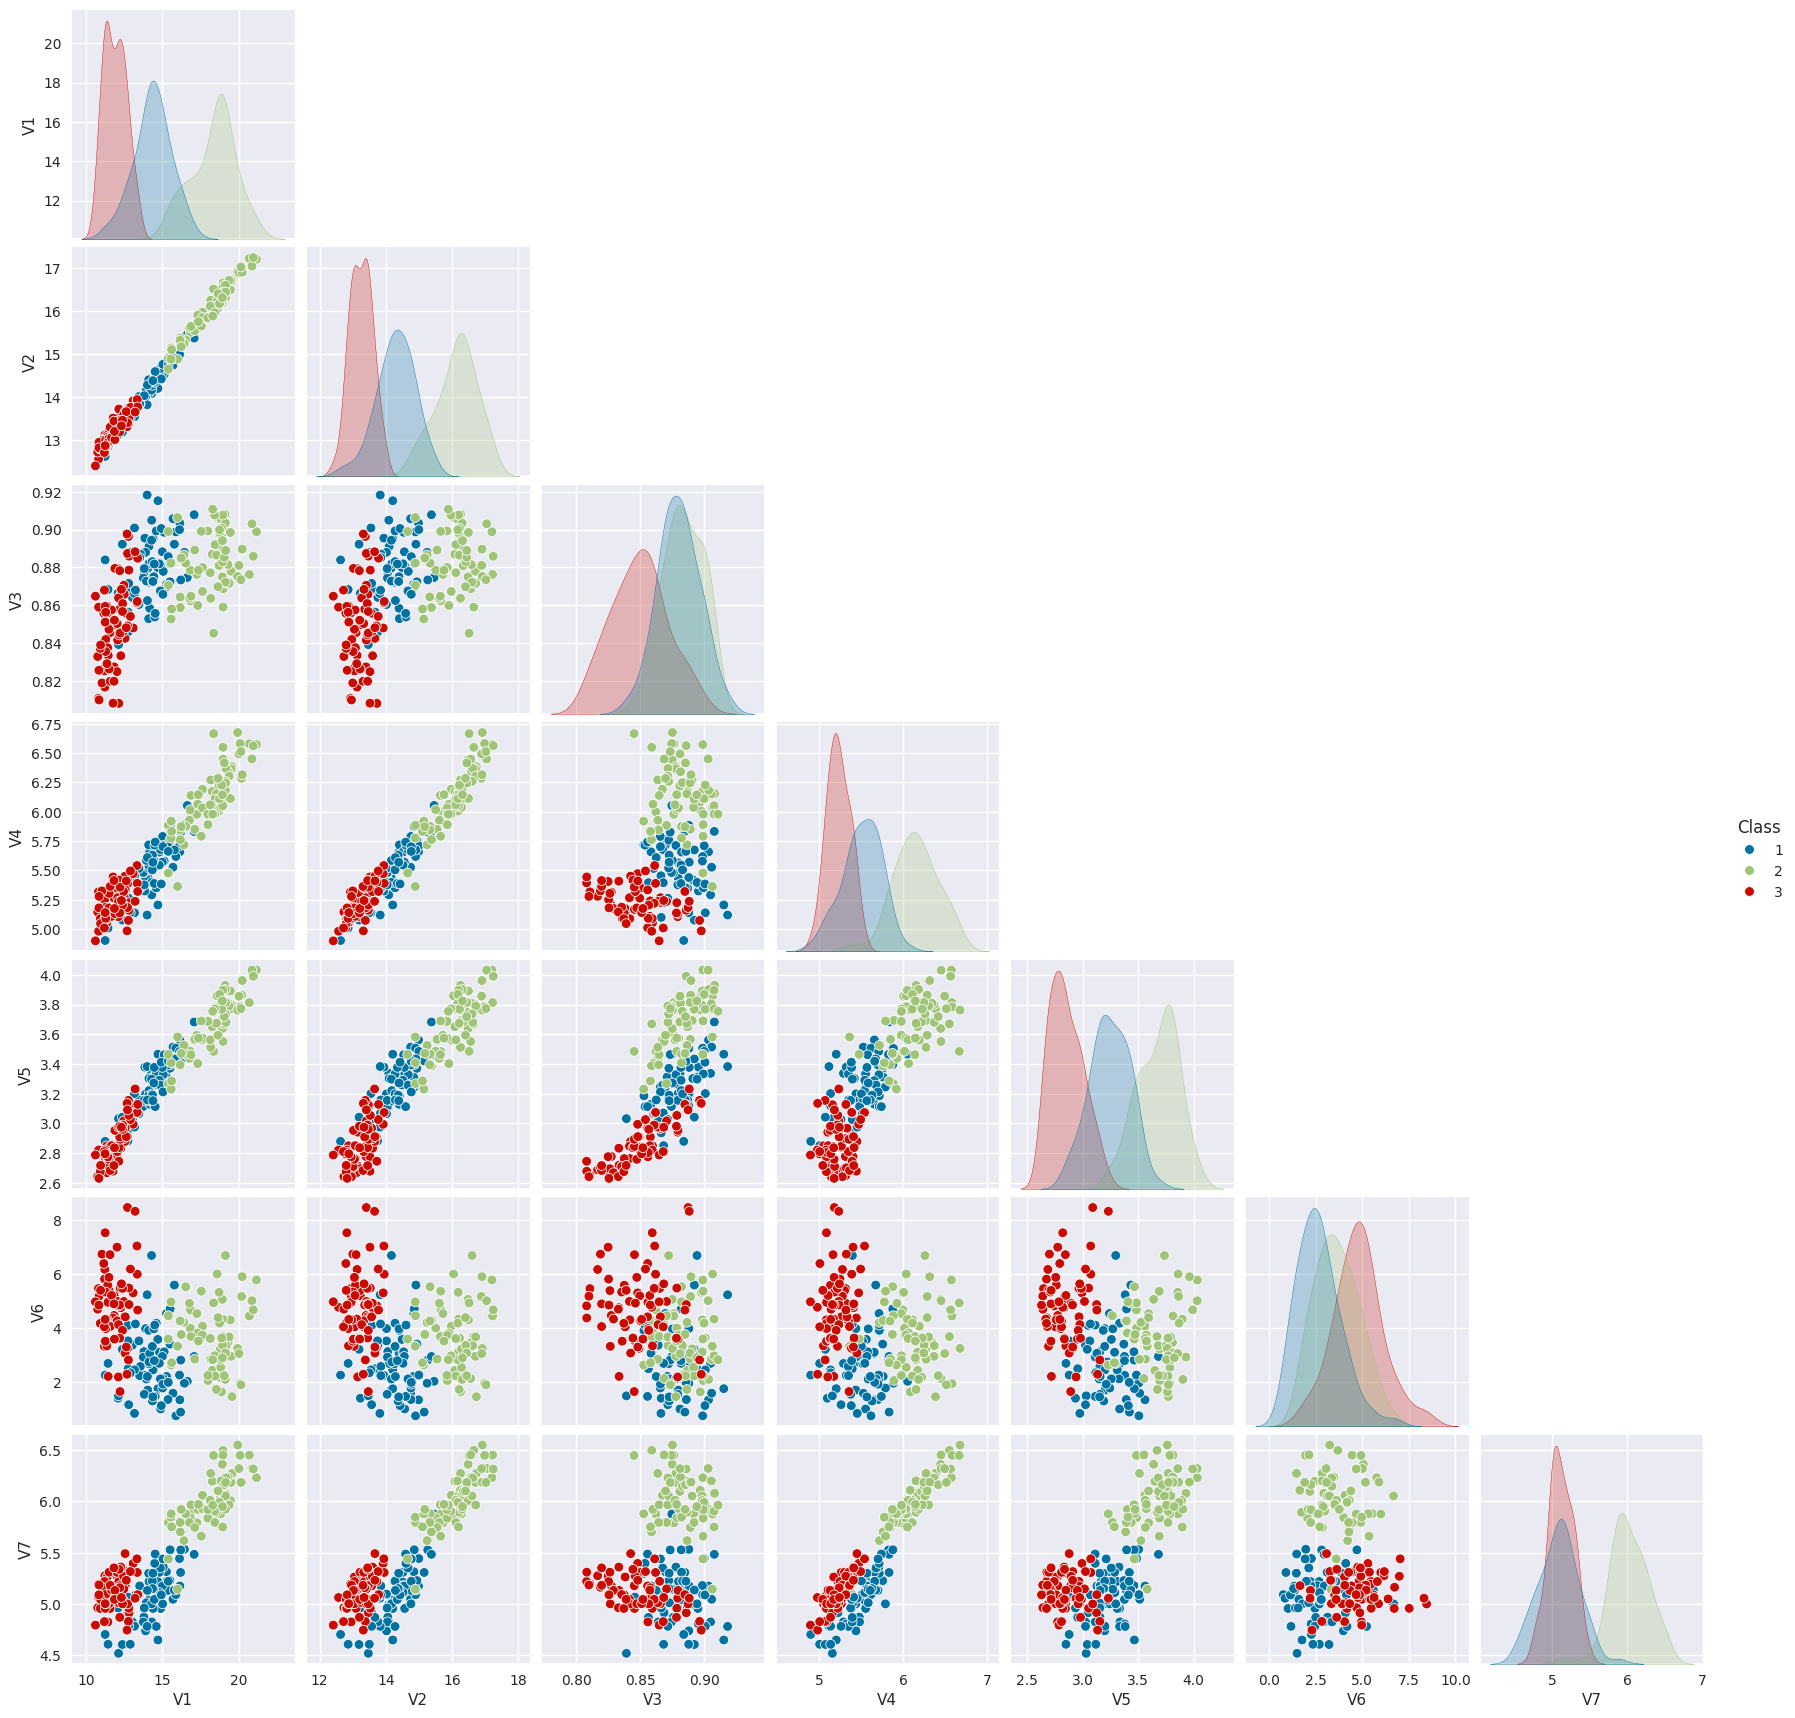

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

iris_plot = sns.pairplot(full_dataset, hue="Class")
iris_plot.map_upper(hide_current_axis)
plt.show()

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(full_dataset)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:00<00:00, 25.46it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Se visualizan los clusters reales, o sea los correspondientes a los target ground truth.

In [ ]:
real_cluster_1 = full_dataset[full_dataset["Class"] == "1"]
real_cluster_2 = full_dataset[full_dataset["Class"] == "2"]
real_cluster_3 = full_dataset[full_dataset["Class"] == "3"]
print("Real cluster 1:\n", real_cluster_1)
print("Real cluster 2:\n", real_cluster_2)
print("Real cluster 3:\n", real_cluster_3)

Real cluster 1:
        V1     V2      V3     V4     V5     V6     V7 Class
0   15.26  14.84  0.8710  5.763  3.312  2.221  5.220     1
1   14.88  14.57  0.8811  5.554  3.333  1.018  4.956     1
2   14.29  14.09  0.9050  5.291  3.337  2.699  4.825     1
3   13.84  13.94  0.8955  5.324  3.379  2.259  4.805     1
4   16.14  14.99  0.9034  5.658  3.562  1.355  5.175     1
..    ...    ...     ...    ...    ...    ...    ...   ...
65  12.88  13.50  0.8879  5.139  3.119  2.352  4.607     1
66  14.34  14.37  0.8726  5.630  3.190  1.313  5.150     1
67  14.01  14.29  0.8625  5.609  3.158  2.217  5.132     1
68  14.37  14.39  0.8726  5.569  3.153  1.464  5.300     1
69  12.73  13.75  0.8458  5.412  2.882  3.533  5.067     1

[70 rows x 8 columns]
Real cluster 2:
         V1     V2      V3     V4     V5     V6     V7 Class
70   17.63  15.98  0.8673  6.191  3.561  4.076  6.060     2
71   16.84  15.67  0.8623  5.998  3.484  4.675  5.877     2
72   17.26  15.73  0.8763  5.978  3.594  4.539  5.791  

Se crea un pipeline con un pequeño preprocesamiento a través de una normalización min-max para las features del entrenamiento, lo cual favorece mucho a los algoritmos. Este pipeline se obtiene a partir del modelo usado en el último step, pero en el preprocesamiento se usa el mismo sea cual sea el modelo.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

def get_pipeline(model):
  return Pipeline([
    ('min_max_scaler', MinMaxScaler()), # normalización sobre las features, que son todas numéricas
    ('model', model)])

Para poder visualizar los clusters obtenidos en torno a un par de las features, para ver en ese par qué tan similares son los agrupamientos en comparación con los reales. Si el algoritmo trabajó con centroides, se grafican estos también junto con sus elementos.

In [ ]:
import matplotlib.pyplot as plt

def visualize_clusters_for_features(X, y, feature1, feature2, model, has_centroids=True):

  plt.scatter(X[:, feature1], X[:, feature2] , s=50)

  plt.grid()
  plt.tight_layout()
  plt.show()

  plt.scatter(X[y == 0, feature1],
              X[y == 0, feature2],
              s=50, c='lightgreen',
              marker='s', edgecolor='black',
              label='Cluster 1')
  plt.scatter(X[y == 1, feature1],
              X[y == 1, feature2],
              s=50, c='orange',
              marker='o', edgecolor='black',
              label='Cluster 2')
  plt.scatter(X[y == 2, feature1],
              X[y == 2, feature2],
              s=50, c='lightblue',
              marker='v', edgecolor='black',
              label='Cluster 3')
  if has_centroids:
    cluster_centers_1 = model.cluster_centers_[:, feature1]
    cluster_centers_2 = model.cluster_centers_[:, feature2]
    plt.scatter(cluster_centers_1,
                cluster_centers_2,
                s=250, marker='*',
                c='red', edgecolor='black',
                label='Centroids')
  plt.legend(scatterpoints=1)
  plt.grid()
  plt.tight_layout()

  plt.show()

Para llevar a cabo una evaluación a través del llamado "método del codo", que tiene en cuenta las distorsiones o inercia del modelo para una cantidad en particular de clusters. De este modo, se evalua hasta encontrar la cantidad de agrupamientos óptima, teniendo en cuenta cómo varía la distorsión. La distorsión tiende a disminuir a medida que se aumenta k debido a que al ser más pequeños y específicos los clusters, sus elementos a nivel general están más cerca del centroide de su grupo. Suele ser preferible tomar la cantidad de clusters de acuerdo al punto en el que empieza a disminuir la tasa de distorsiones en menor medida (pasarse tampoco es bueno, ya que serían clusters demasiados pequeños).

In [ ]:
from sklearn.cluster import KMeans

def evaluate_model_with_elbow_method(model_name): # criterio interno de evaluación
  distortions = []
  for i in range(1, 11):
      if model_name == "kmeans":
        pipeline_instance = get_pipeline(KMeans(n_clusters=i,
                                init='random',
                                n_init=10,
                                max_iter=300,
                                random_state=42))
      elif model_name == "kmeans++": # no se pregunta si es un clustering aglomerativo ya que no tiene sentido para ese tipo de modelo evaluar a través de la inercia, y por lo tanto tampoco a través de elbow method
        pipeline_instance = get_pipeline(KMeans(n_clusters=3,
                                        init='k-means++',
                                        n_init=10,
                                        max_iter=300,
                                        tol=1e-04,
                                        random_state=42))
      pipeline_instance.fit(features)
      distortions.append(pipeline_instance['model'].inertia_)
  print(distortions)
  plt.plot(range(1, 11), distortions, marker='o')
  plt.plot(3, distortions[3], 'r*',marker='x')
  plt.xlabel('Number of clusters')
  plt.ylabel('Distortion')
  plt.tight_layout()

  plt.show()

Para realizar una evaluación por medio de un "gráfico de silueta", determinando qué tan bien agrupado en su grupo están los elementos de un cluster. Las siluetas varían entre -1 y 1, siendo que -1 indica un agrupamiento muy malo siendo que el elemento está más cerca de un cluster que del que realmente debería estar. Si es 0 quiere decir que el elemento se encuentra en la frontera entre dos clusters y podría pertenecer a cualquiera de los dos de manera indistinta, por lo que el agrupamiento no se puede considerar bueno pero tampoco malo (no es bueno porque sería preferible encontrar otra posible clusterización de ese conjunto de datos en el que el elemento pertenezca indudablemente a un cluster). Por último, si es 1 significa que el agrupamiento es excelente, el elemento está bien clusterizado y a su vez es lejano a otros grupos.

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

def evaluate_model_with_silhouette_score(model, X_preprocessed): # criterio interno de evaluación

  visualizer = SilhouetteVisualizer(model, colors='yellowbrick') # aunque el model ya este entrenado, al pasarle los datos originales con las mismas transformaciones internamente da lo mismo, por lo que los resultados del visualizer son consistentes con los del entrenamiento
  visualizer.fit(X_preprocessed)
  visualizer.poof()

Para evaluar la clusterización a través de un método por criterio externo, que básicamente consiste en comparar el agrupamiento obtenido con el que conforman las clases reales de los elementos. Lógicamente esto solo es posible si se cuenta con dichos targets, lo cual en muchas ocasiones no ocurre para este tipo de casos, pero puede ocurrir que sí (por ejemplo si se tiene una clasificación pevia pero se quieren explorar nuevos posibles agrupamientos basados en características que son más complejas de identificar a simple vista, o si son tan pocos los datos etiquetados que no dan lugar a un entrenamiento supervisado robusto y se tiene que incurrir en no supervisado). Las distintas métricas que se considerarán son las siguientes:

**Homogeneidad:** Un resultado de agrupación satisface la homogeneidad si todos sus grupos contienen solo puntos de datos que son miembros de una sola clase.

**Completitud:** Un resultado de agrupación satisface la completidued si todos los puntos de datos que son miembros de una clase dada son elementos del mismo grupo.

**V-measure:** La medida V es la media armónica entre homogeneidad e completitud:

**Indice Rand:** Calcula una medida de similitud entre dos agrupaciones al considerar todos los pares de muestras y contar pares que se asignan en el mismo grupo o en grupos diferentes.

In [ ]:
from sklearn import metrics

def evaluate_model_with_external_criteria(target_predictions):

  print("Homogeneity: %0.3f" % metrics.homogeneity_score(original_targets, target_predictions))
  print("Completeness: %0.3f" % metrics.completeness_score(original_targets, target_predictions))
  print("V-measure: %0.3f" % metrics.v_measure_score(original_targets, target_predictions))
  print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(original_targets, target_predictions))

$c)$ Se decidió aplicar clustering para agrupar los datos a partir de dos modelos principales, el primero de ellos es el de **KMeans**. Este consiste en encontrar ciertos centroides de tal manera que cada elemento pertenezca al cluster asociado a su centroide más cercano. Algunos aspectos considerados para su eleccción son:

- Su simpleza y eficiencia.
- Sabiendo de antemano que una posible división es en 3 clusters, resulta en una gran ventaja poder usar este algoritmo conociendo cuál es la cantidad k de clusters ideal (o por lo menos ideal para el problema real, ya que en términos de agrupamiento puede que algunos grupos más den mejores métrica intrínsecas). Eso "mitiga" una de las desventajas de este modelo que es el hecho de tener que establecer la cantidad k de clusters de antemano.
- El análisis del dataset pareció haber una cantidad razonable de mínimos y máximos locales, sin presencia exagerada de outliers, que son aspectos que hacen rendir peor a modelos de este tipo.

En cuanto a la configuración elegida, se decidió lo siguiente:

- Inicialización random, para elegir de manera aleatoria los clusters iniciales de entre el conjunto de datos.
- Cantidad de corridas del algoritmo de 10, de las cuales se elegirá el mejor agrupamiento en base al que cuente con menor inercia.
- Un máximo de 300 iteraciones por corrida del algoritmo.
- Una tolerancia de 1e⁻4 que indica cuál es el límite del SSE para la convergencia (sum of squared errors, o sea la inercia). Si es menor a este entre dos iteraciones, quiere decir que los centroides prácticamente no variaron para el criterio tomado, por lo qe se llega al final del agrupamiento para esa corrida.
- Una semilla aleatoria 42 para garantizar la reproducibilidad del algoritmo puesto que usa aleatoriedad.

Luego se aplicó una variante de la inicialización de este mismo algoritmo conocida como **KMeans++** (únicamente varía la inicialización, por eso no se lo consideró como el segundo modelo a elegir, solo una variación del anterior). La principal diferencia radica en que con esta alternativa se eligen de forma "inteligente" los clusters iniciales, seleccionando el primer centroide al azar, y luego los siguientes con una probabilidad proporcional a su distancia a los centroides ya elegidos. De esta forma, se distribuyen mejor los centroides y se acelera la convergencia. Se eligió la misma configuración a excepción de la inicialización para evaluar concretamente si hubo mejoras en este caso debido a dicha inicialización.

Más adelante se aplicó el segundo modelo, llamado **Clustering Aglomerativo Jerárquico**. Lo que este algoritmo del tipo bottom-up hace es partir de todos los elementos en clusters separados e ir combinando dichos clusters en clusters más grandes. De esta forma, llega un momento que se llega al grupo más general que engloba todos los datos. Se utiliza una función de similitud entre elementos en sí y una función de similitud entre clusters que puede ser del tipo Single Link, Complete Link o Group/Average Link. Consideraciones tomadas al momento de elegir este algoritmo fueron:
- No tener que elegir la cantidad de clusters antes de correr el algoritmo. Se deja que este vaya descubriendo el número de clusters que correspondan.
- Tiene la desventaja que no se recupera de decisiones incorrectas y es costoso computacionalmente.
- Al contar con un dataset con un tamaño no tan grande, no resulta problemático el hecho de que este algoritmo no escala bien con muchas entradas.

Se probó con distintas configuraciones de este algoritmo, con las siguientes características:
- Todas ellas con 3 clusters iniciales.
- Todas ellas con distancia euclideana.
- Una con función de similitud entre clusters de Single Link, otra con Complete Link y finalmente con Group Average.

In [ ]:
from sklearn.cluster import KMeans

pipeline_km = get_pipeline(KMeans(n_clusters=3,
                            init='random',
                            n_init=10,
                            max_iter=300,
                            tol=1e-04,
                            random_state=42))
y_km = pipeline_km.fit_predict(features)
X_preprocessed = pipeline_km[:-1].transform(features) # para obtener el X preprocesado y asi graficar los centroides y predicciones, que obviamente estan afectados por ese preprocesamiento, en base al mismo
model_km = pipeline_km['model']

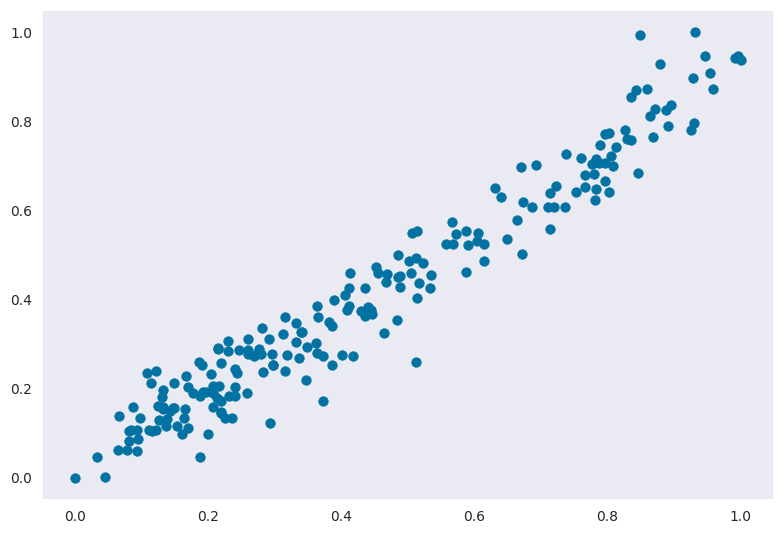

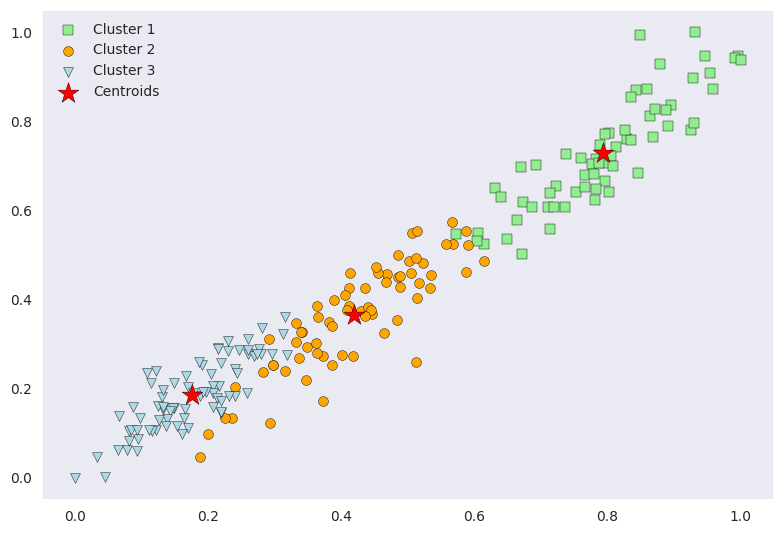

In [ ]:
idx_v2 = features.columns.get_loc("V2")
idx_v4 = features.columns.get_loc("V4")

visualize_clusters_for_features(X_preprocessed, y_km, idx_v2, idx_v4, model_km)

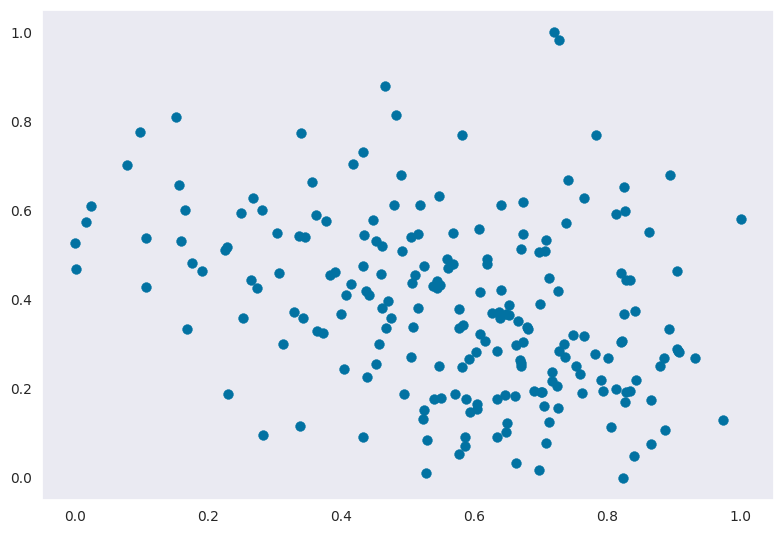

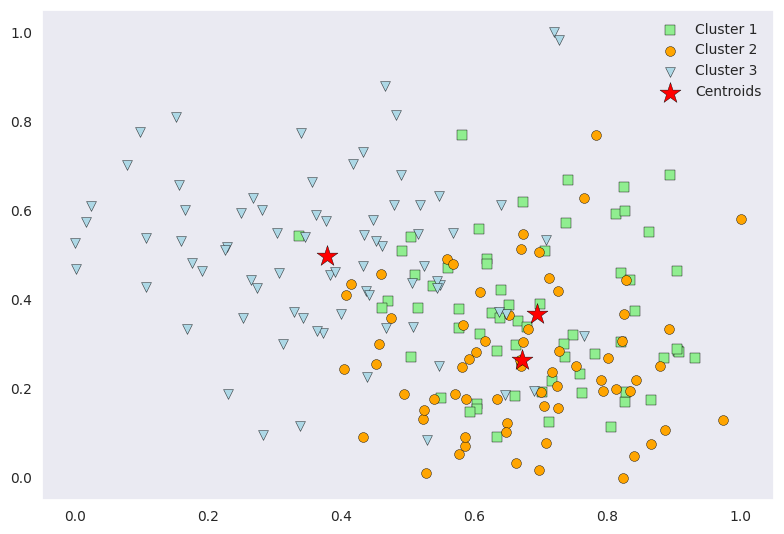

In [ ]:
idx_v3 = features.columns.get_loc("V3")
idx_v6 = features.columns.get_loc("V6")

visualize_clusters_for_features(X_preprocessed, y_km, idx_v3, idx_v6, model_km)

In [ ]:
evaluate_model_with_external_criteria(y_km)

Homogeneity: 0.673
Completeness: 0.675
V-measure: 0.674
Adjusted Rand-Index: 0.705


[88.98592483911847, 34.813267926945606, 22.024363075666034, 18.690354418827546, 16.186984905410167, 14.836193616805692, 13.27867254456366, 12.14006242434169, 11.042477962520277, 10.462070170881207]


<ipython-input-114-3621e0a9eb0c>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(3, distortions[3], 'r*',marker='x')


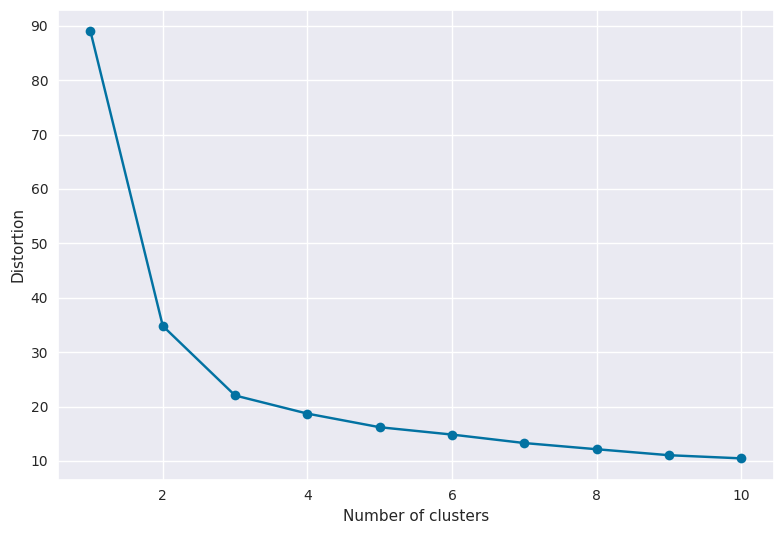

In [ ]:
evaluate_model_with_elbow_method("kmeans")

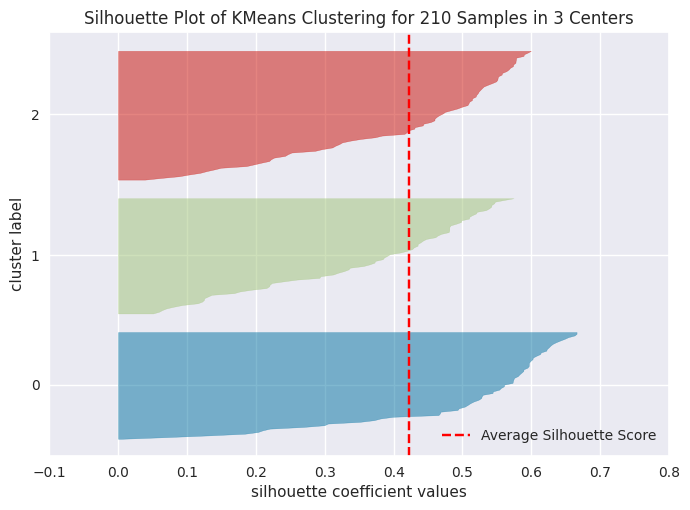

In [ ]:
evaluate_model_with_silhouette_score(model_km, X_preprocessed)

In [ ]:
from sklearn.cluster import KMeans

pipeline_km_pp = get_pipeline(KMeans(n_clusters=3,
                        init='k-means++',
                        n_init=10,
                        max_iter=300,
                        tol=1e-04,
                        random_state=42))
y_km_pp = pipeline_km_pp.fit_predict(features)
X_preprocessed = pipeline_km_pp[:-1].transform(features)
model_km_pp = pipeline_km_pp['model']

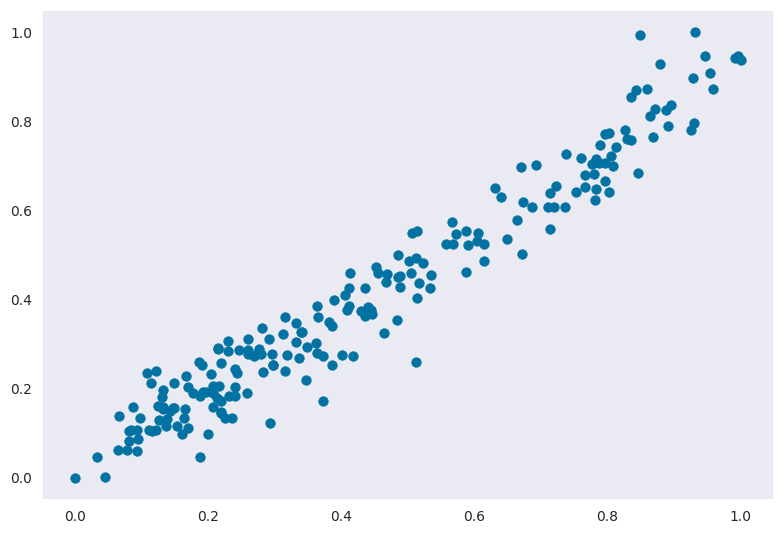

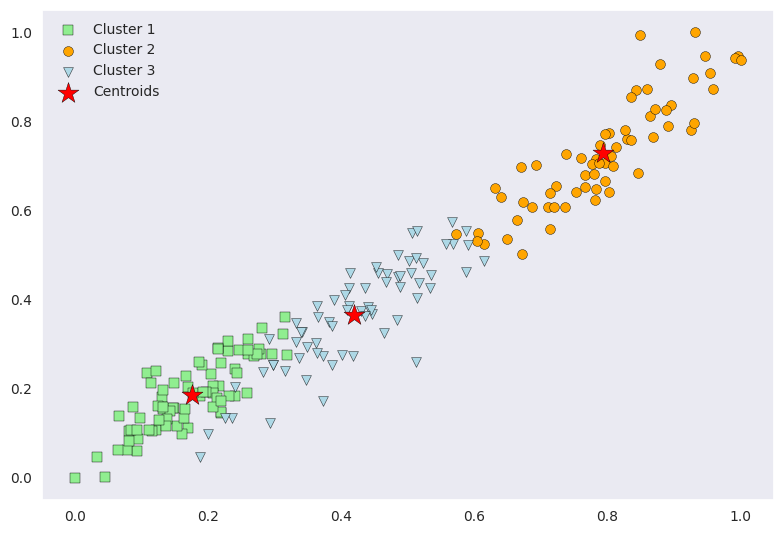

In [ ]:
idx_v2 = features.columns.get_loc("V2")
idx_v4 = features.columns.get_loc("V4")

visualize_clusters_for_features(X_preprocessed, y_km_pp, idx_v2, idx_v4, model_km_pp)

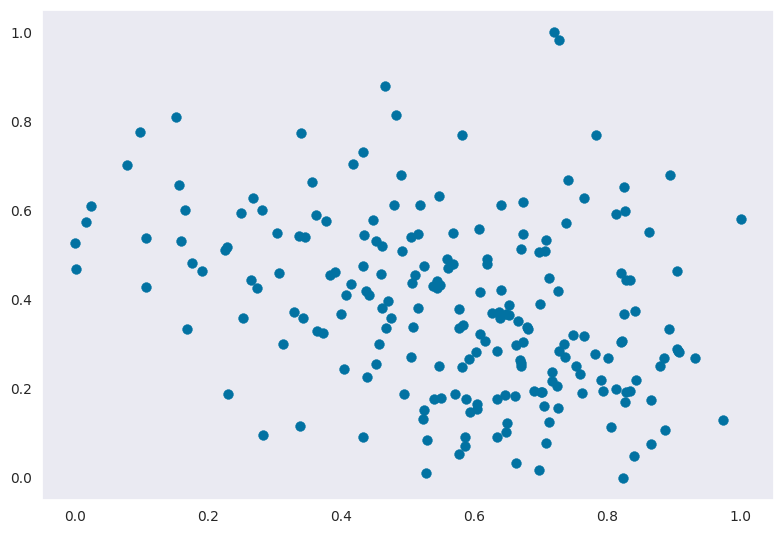

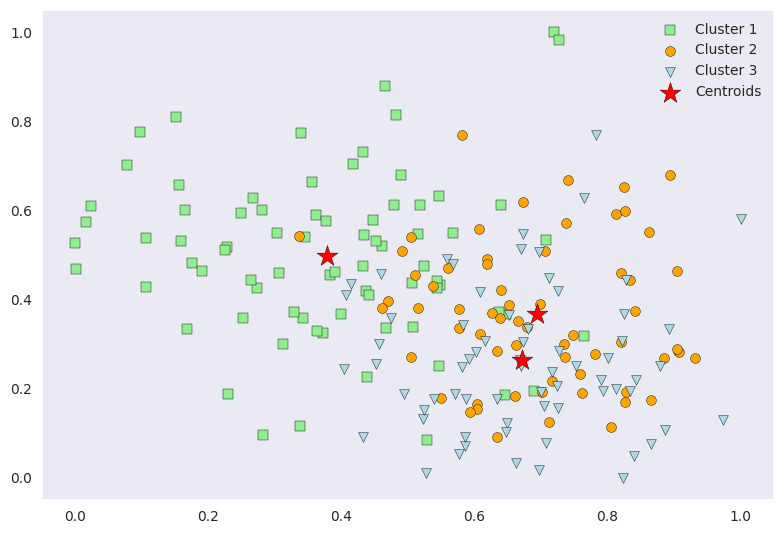

In [ ]:
idx_v3 = features.columns.get_loc("V3")
idx_v6 = features.columns.get_loc("V6")

visualize_clusters_for_features(X_preprocessed, y_km_pp, idx_v3, idx_v6, model_km_pp)

In [ ]:
evaluate_model_with_external_criteria(y_km_pp)

Homogeneity: 0.673
Completeness: 0.675
V-measure: 0.674
Adjusted Rand-Index: 0.705


[22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034, 22.024363075666034]


<ipython-input-114-3621e0a9eb0c>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r*" (-> marker='*'). The keyword argument will take precedence.
  plt.plot(3, distortions[3], 'r*',marker='x')


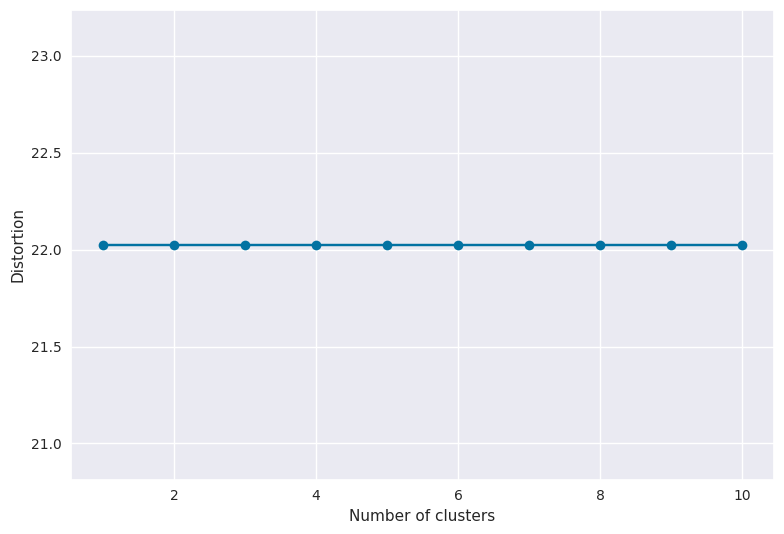

In [ ]:
evaluate_model_with_elbow_method("kmeans++")

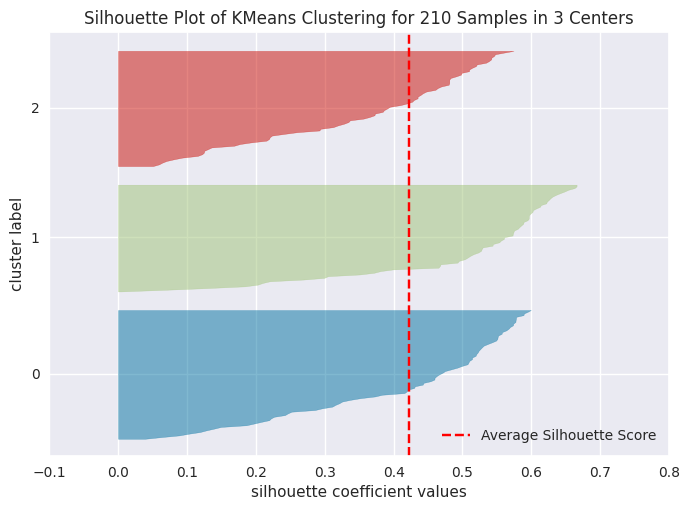

In [ ]:
evaluate_model_with_silhouette_score(model_km_pp, X_preprocessed)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

pipeline_acs = get_pipeline(AgglomerativeClustering(
                            n_clusters=3,
                            metric='euclidean',
                            linkage='single'))

y_acs = pipeline_acs.fit_predict(features)
X_preprocessed = pipeline_acs[:-1].transform(features)
model_acs = pipeline_acs['model']

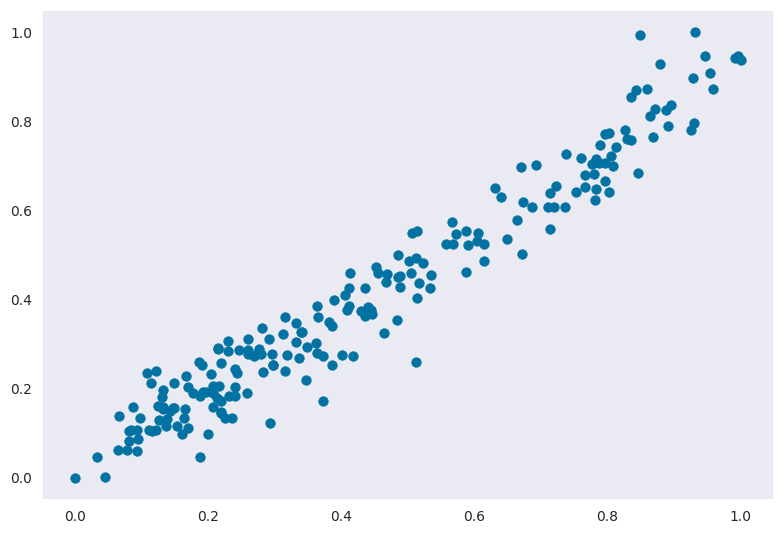

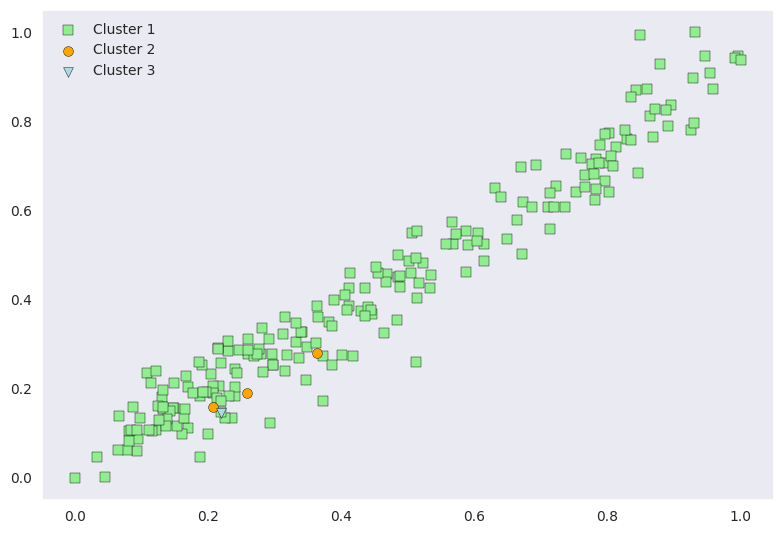

In [ ]:
idx_v2 = features.columns.get_loc("V2")
idx_v4 = features.columns.get_loc("V4")

visualize_clusters_for_features(X_preprocessed, y_acs, idx_v2, idx_v4, model_acs, has_centroids=False)

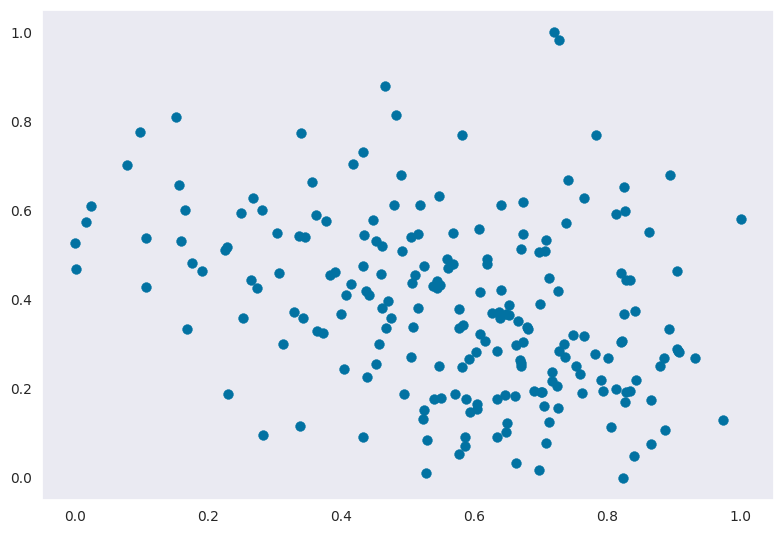

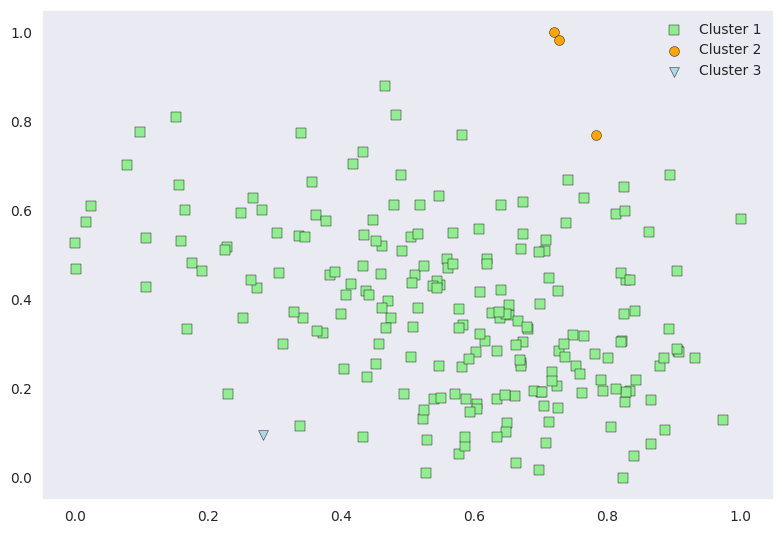

In [ ]:
idx_v3 = features.columns.get_loc("V3")
idx_v6 = features.columns.get_loc("V6")

visualize_clusters_for_features(X_preprocessed, y_acs, idx_v3, idx_v6, model_acs, has_centroids=False)

In [ ]:
evaluate_model_with_external_criteria(y_acs)

Homogeneity: 0.011
Completeness: 0.114
V-measure: 0.020
Adjusted Rand-Index: 0.000


In [ ]:
from sklearn.cluster import AgglomerativeClustering

pipeline_acc = get_pipeline(AgglomerativeClustering(
                            n_clusters=3,
                            metric='euclidean',
                            linkage='complete'))

y_acc = pipeline_acc.fit_predict(features)
X_preprocessed = pipeline_acc[:-1].transform(features)
model_acc = pipeline_acc['model']

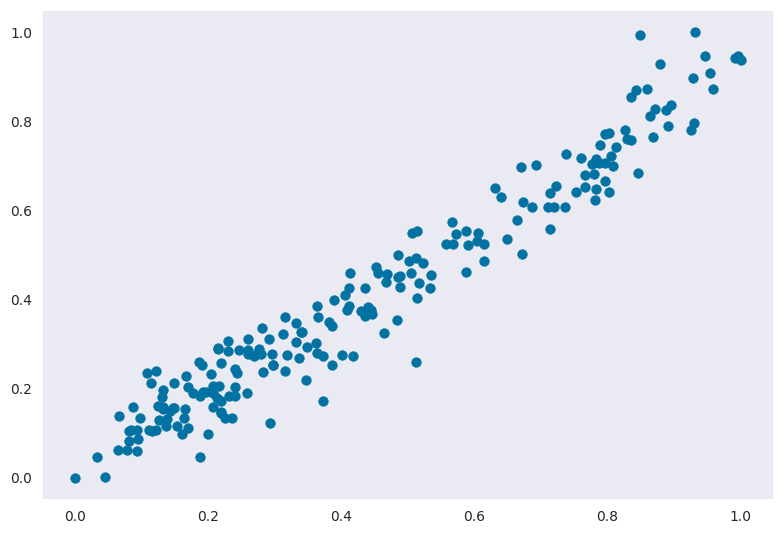

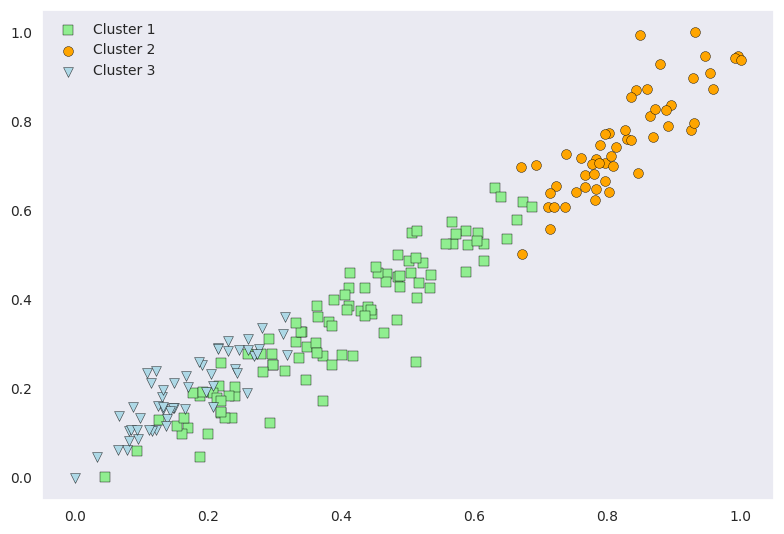

In [ ]:
idx_v2 = features.columns.get_loc("V2")
idx_v4 = features.columns.get_loc("V4")

visualize_clusters_for_features(X_preprocessed, y_acc, idx_v2, idx_v4, model_acc, has_centroids=False)

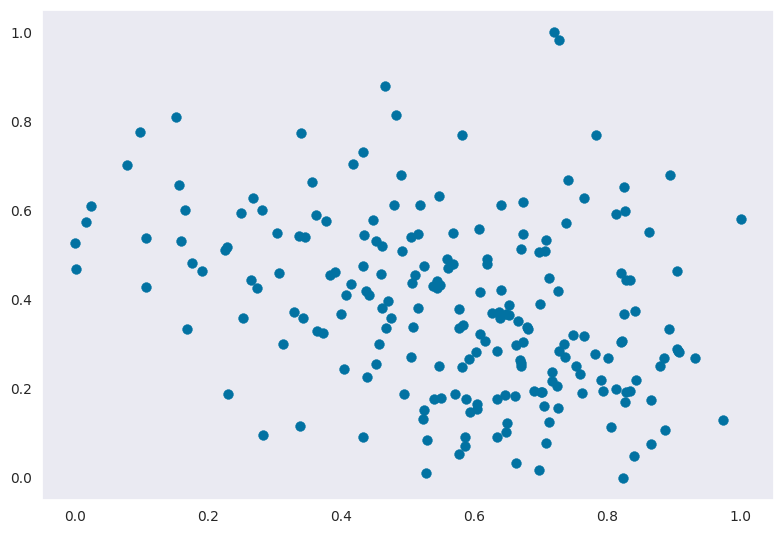

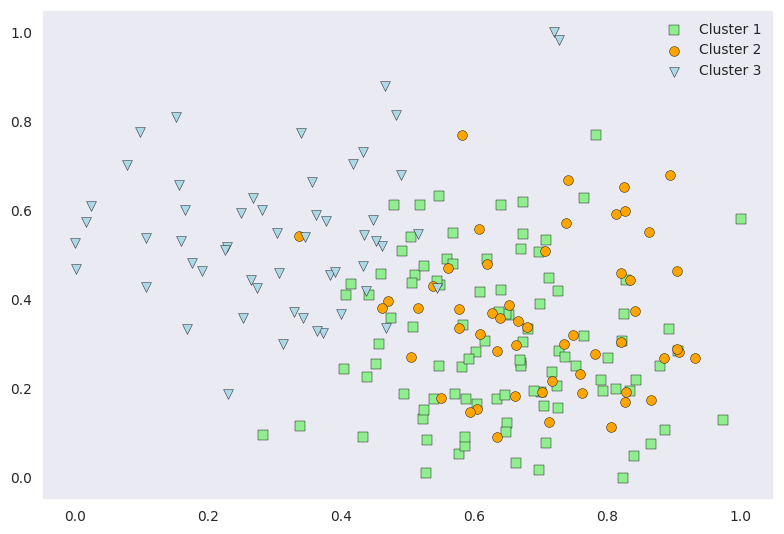

In [ ]:
idx_v3 = features.columns.get_loc("V3")
idx_v6 = features.columns.get_loc("V6")

visualize_clusters_for_features(X_preprocessed, y_acc, idx_v3, idx_v6, model_acc, has_centroids=False)

In [ ]:
evaluate_model_with_external_criteria(y_acc)

Homogeneity: 0.609
Completeness: 0.636
V-measure: 0.622
Adjusted Rand-Index: 0.566


In [ ]:
from sklearn.cluster import AgglomerativeClustering

pipeline_aca = get_pipeline(AgglomerativeClustering(
                            n_clusters=3,
                            metric='euclidean',
                            linkage='average'))

y_aca = pipeline_aca.fit_predict(features)
X_preprocessed = pipeline_aca[:-1].transform(features)
model_aca = pipeline_aca['model']

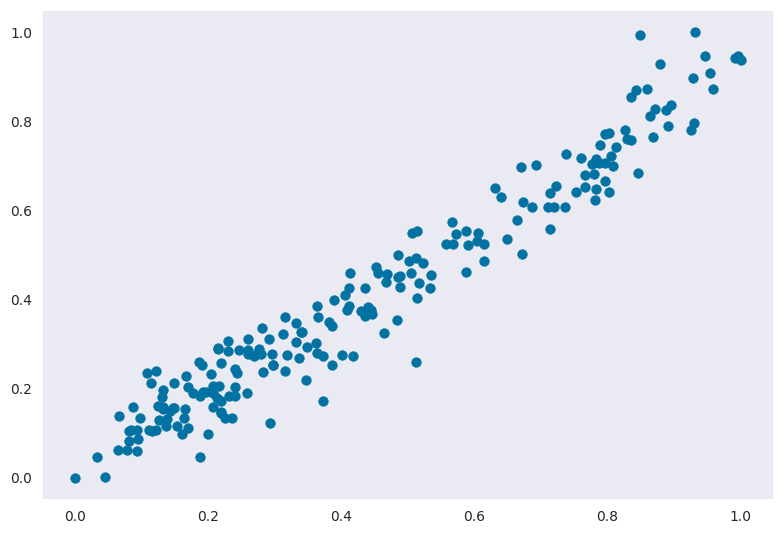

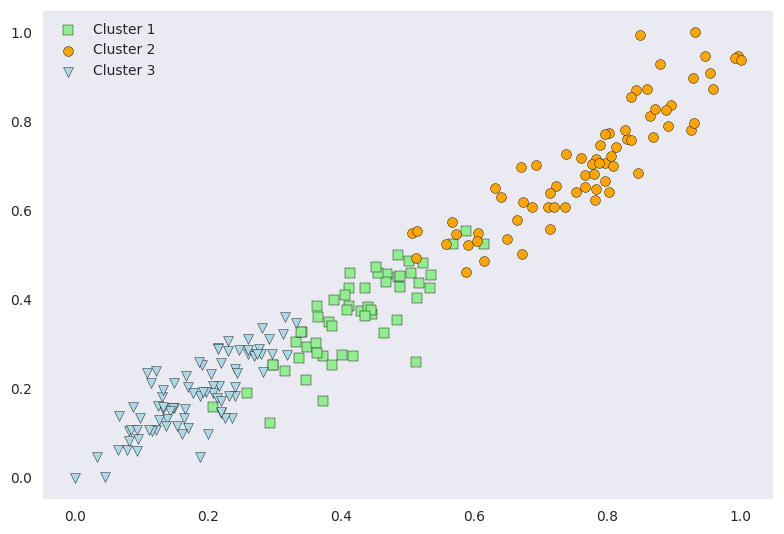

In [ ]:
idx_v2 = features.columns.get_loc("V2")
idx_v4 = features.columns.get_loc("V4")

visualize_clusters_for_features(X_preprocessed, y_aca, idx_v2, idx_v4, model_aca, has_centroids=False)

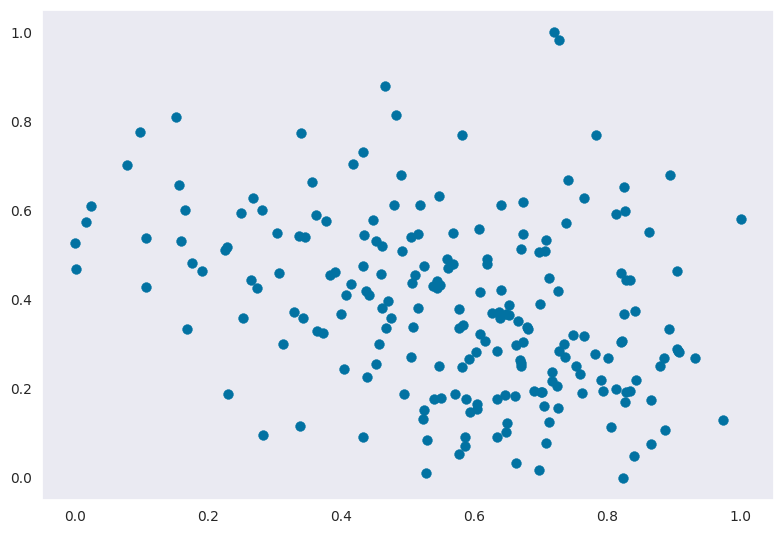

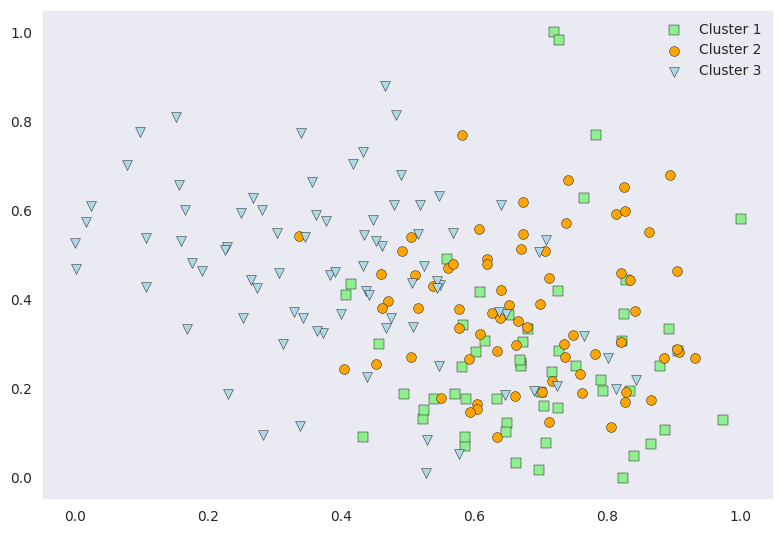

In [ ]:
idx_v3 = features.columns.get_loc("V3")
idx_v6 = features.columns.get_loc("V6")

visualize_clusters_for_features(X_preprocessed, y_aca, idx_v3, idx_v6, model_aca, has_centroids=False)

In [ ]:
evaluate_model_with_external_criteria(y_aca)

Homogeneity: 0.702
Completeness: 0.710
V-measure: 0.706
Adjusted Rand-Index: 0.725


$d)$ Al evaluar los distintos modelos entrenados con los algoritmos ya vistos se pudo llegar a las siguientes conclusiones:

- Para todos los casos, a excepción del Clustering Aglomerativo Jerárquico con función de similitud inter-cluster de Single Link (donde los resultados son muy malos), se pudo agrupar relativamente bien a los elementos. Para todos esos casos fueron analizadas concretamente la relación de la feature V2 en función de V4 y de V3 en función de V6. En cuanto a la primera de ellas los modelos demostraron que su clusterización respetaba esa correlación que estas features demostraban tener en el análisis del dataset respecto a los verdaderos targets.
- El mejor resultado en análisis externo (que no siempre se puede hacer pero en este caso sí, y tiene mucho peso porque evalua basándose en las clases reales) fue para el modelo de Clustering Aglomerativo Jerárquico con función de similitud inter-cluster de Group/Average Link. Este logró una homogeneidad del 0,702, una completitud de 0,710, V-Measure de 0,706 y Adjusted Rand-Index de 0,725. Con esos resultados superó en todas las métricas de análisis externo elegidas al resto de los modelos. La función de Group/Average Link lo que hace es considerar la similitud como el promedio las similitudes entre
los ejemplos entre los clusters. Es evidente que en este caso fue mejor que el resto.
- El peor resultado en análisis externo fue para el modelo de Clustering Aglomerativo Jerárquico con función de similitud inter-cluster de Single Link. Este algoritmo, que con gran error agrupó casi todos los elementos en un mismo cluster, tuvo los resultados de homogeneidad del 0,011, una completitud de 0,114, V-Measure de 0,020 y Adjusted Rand-Index de 0.
- Para las evaluaciones por criterios intrínsecos que se aplicaron sobre los modelos de KMeans y KMeans++, se obtuvieron los mismos resultados, lo que sugiere que la agrupación inicial para el algoritmo no está interfiriendo en ello. Además, los resultados por criterios externos para este son una homogeneidad de 0,673, completitud de 0,675, V-Measure de 0,674 y Adjusted Rand-Index de 0,705.

Debido a estos resultados, el modelo elegido es el de Clustering Aglomerativo Jerárquico con función de similitud inter-cluster de Single Link, esencialmente por sus grandes resultados en la evaluación externa, lo que demuestra su alto grado de similitud en sus resultados para 3 clusters respecto a los targets originales del problema.